In [2]:
import numpy as np
import pandas as pd

import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    KFold,
    train_test_split,
    cross_val_score,
    RepeatedKFold,
    GridSearchCV,
)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.multioutput import MultiOutputRegressor
import shap
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
%matplotlib inline

In [3]:
df = pd.read_csv("./data/current_allday_data.csv.gz")

datecols = ["Datetime", "Date"]
intcols = ["Price", "Sales_Count"]

df[datecols] = df[datecols].apply(pd.to_datetime)
df[intcols] = df[intcols].apply(pd.to_numeric, downcast='integer')

In [4]:
df

,Datetime,Date,tx_id,Price,Buyer,Seller,Player,Team,Position,Season,...,Weight,image,Classification,Total_Circulation,Moment_Description,NFT_ID,Series,Set_Name,NFLALLDAY_ASSETS_URL,Sales_Count
0,2022-05-05 18:49:07,2022-05-05,5d4baa454da25b04d5af5cad22f971ed91ac69ea76f444...,10,0x4c0395008889aa20,0x62754bf5d9f9bdd5,Randall Cunningham,Philadelphia Eagles,QB,1987,...,195.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,9000,Randall Cunningham rolled to his left off of p...,2555093,Historical,Gridiron,https://assets.nflallday.com/editions/gridiron...,1
1,2022-06-15 21:39:01,2022-06-15,6c96ca996a0991d3d3d867c56ef80e53491d1ee7f11fed...,4,0x1762f9a119427234,0x66443cafc920078c,A'Shawn Robinson,Los Angeles Rams,DL,2021,...,330.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,A'Shawn Robinson pushed his way through the li...,1498641,Series 1,Base,https://assets.nflallday.com/editions/base/4b0...,1
2,2022-06-15 19:34:54,2022-06-15,9b40c0168a145f926bea136dbbdaea18911a8715829e75...,220,0xb8eab8b330b6d8f3,0x4d2728f9b1f48c48,A.J. Brown,Tennessee Titans,WR,2021,...,226.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,899,Knowing he had a free play after San Francisco...,1311057,Series 1,Launch Codes,https://assets.nflallday.com/editions/launch_c...,1
3,2022-06-15 19:14:24,2022-06-15,44ed87333faebe4d1c3f038f855c7ed8fafaa8d03b1702...,32,0x3a8896d9962c3edf,0x7dece7a1d46ee9c5,A.J. Brown,Tennessee Titans,WR,2021,...,226.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,8500,Blanketed by two defenders near the pylon alon...,2233227,Series 1,Divisional Round,https://assets.nflallday.com/editions/division...,1
4,2022-06-15 20:27:38,2022-06-15,75fe78789e82547c329cb9f7c1ccfcea8495e72b08d3dd...,6,0x2bbe4f847f5d1758,0x4d2728f9b1f48c48,A.J. Green,Arizona Cardinals,WR,2021,...,210.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,8000,A.J. Green posted up in the middle of the Seat...,1951312,Series 1,Move the Chains,https://assets.nflallday.com/editions/move_the...,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602770,2022-09-21 09:36:07,2022-09-21,9d6ecd925535329504e43f4a0fe4f9fe3d10883faa3dd9...,35,0x5bb7e65418eb1d4c,0x9f969fa0351ca6b0,Zach Wilson,New York Jets,QB,2021,...,214.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zach Wilson saw the field open up in front of ...,564156,Series 1,Base,https://assets.nflallday.com/editions/base/7aa...,1
602771,2022-09-21 11:31:41,2022-09-21,c0a13ddf4774853713bb5974c00e22715db4e67d079204...,33,0x971a99ee34308dff,0x97475da29ad1ab8e,Zach Wilson,New York Jets,QB,2021,...,214.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zach Wilson saw the field open up in front of ...,561731,Series 1,Base,https://assets.nflallday.com/editions/base/7aa...,1
602772,2022-09-21 06:03:46,2022-09-21,72e40116dca4db82a6ec568d239a88905733c3351424cd...,9,0x1f0315e9e83c607d,0xf44c2d2b8f508092,Zay Jones,Las Vegas Raiders,WR,2021,...,200.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zay Jones broke toward the near sideline on th...,1472935,Series 1,Base,https://assets.nflallday.com/editions/base/b2f...,3
602773,2022-09-21 05:26:57,2022-09-21,f60a36ab97353b9c579419a72b2bfb42db78eda6a5ff13...,8,0xf44c2d2b8f508092,0x542e12f2d29b171e,Zay Jones,Las Vegas Raiders,WR,2021,...,200.0,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zay Jones broke toward the near sideline on th...,1472935,Series 1,Base,https://assets.nflallday.com/editions/base/b2f...,3


In [5]:
# adding here for now, will be added to the data creation step
 
df['Resell_Number'] = ( df.groupby("NFT_ID")["tx_id"]
        .cumcount()

        # .sort_values(by="tx_id")
        # .rename(columns={"tx_id": "Sales_Count"})
       )

In [6]:
df

,Datetime,Date,tx_id,Price,Buyer,Seller,Player,Team,Position,Season,...,image,Classification,Total_Circulation,Moment_Description,NFT_ID,Series,Set_Name,NFLALLDAY_ASSETS_URL,Sales_Count,Resell_Number
0,2022-05-05 18:49:07,2022-05-05,5d4baa454da25b04d5af5cad22f971ed91ac69ea76f444...,10,0x4c0395008889aa20,0x62754bf5d9f9bdd5,Randall Cunningham,Philadelphia Eagles,QB,1987,...,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,9000,Randall Cunningham rolled to his left off of p...,2555093,Historical,Gridiron,https://assets.nflallday.com/editions/gridiron...,1,0
1,2022-06-15 21:39:01,2022-06-15,6c96ca996a0991d3d3d867c56ef80e53491d1ee7f11fed...,4,0x1762f9a119427234,0x66443cafc920078c,A'Shawn Robinson,Los Angeles Rams,DL,2021,...,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,A'Shawn Robinson pushed his way through the li...,1498641,Series 1,Base,https://assets.nflallday.com/editions/base/4b0...,1,0
2,2022-06-15 19:34:54,2022-06-15,9b40c0168a145f926bea136dbbdaea18911a8715829e75...,220,0xb8eab8b330b6d8f3,0x4d2728f9b1f48c48,A.J. Brown,Tennessee Titans,WR,2021,...,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,899,Knowing he had a free play after San Francisco...,1311057,Series 1,Launch Codes,https://assets.nflallday.com/editions/launch_c...,1,0
3,2022-06-15 19:14:24,2022-06-15,44ed87333faebe4d1c3f038f855c7ed8fafaa8d03b1702...,32,0x3a8896d9962c3edf,0x7dece7a1d46ee9c5,A.J. Brown,Tennessee Titans,WR,2021,...,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,8500,Blanketed by two defenders near the pylon alon...,2233227,Series 1,Divisional Round,https://assets.nflallday.com/editions/division...,1,0
4,2022-06-15 20:27:38,2022-06-15,75fe78789e82547c329cb9f7c1ccfcea8495e72b08d3dd...,6,0x2bbe4f847f5d1758,0x4d2728f9b1f48c48,A.J. Green,Arizona Cardinals,WR,2021,...,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,8000,A.J. Green posted up in the middle of the Seat...,1951312,Series 1,Move the Chains,https://assets.nflallday.com/editions/move_the...,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602770,2022-09-21 09:36:07,2022-09-21,9d6ecd925535329504e43f4a0fe4f9fe3d10883faa3dd9...,35,0x5bb7e65418eb1d4c,0x9f969fa0351ca6b0,Zach Wilson,New York Jets,QB,2021,...,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zach Wilson saw the field open up in front of ...,564156,Series 1,Base,https://assets.nflallday.com/editions/base/7aa...,1,0
602771,2022-09-21 11:31:41,2022-09-21,c0a13ddf4774853713bb5974c00e22715db4e67d079204...,33,0x971a99ee34308dff,0x97475da29ad1ab8e,Zach Wilson,New York Jets,QB,2021,...,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zach Wilson saw the field open up in front of ...,561731,Series 1,Base,https://assets.nflallday.com/editions/base/7aa...,1,0
602772,2022-09-21 06:03:46,2022-09-21,72e40116dca4db82a6ec568d239a88905733c3351424cd...,9,0x1f0315e9e83c607d,0xf44c2d2b8f508092,Zay Jones,Las Vegas Raiders,WR,2021,...,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zay Jones broke toward the near sideline on th...,1472935,Series 1,Base,https://assets.nflallday.com/editions/base/b2f...,3,0
602773,2022-09-21 05:26:57,2022-09-21,f60a36ab97353b9c579419a72b2bfb42db78eda6a5ff13...,8,0xf44c2d2b8f508092,0x542e12f2d29b171e,Zay Jones,Las Vegas Raiders,WR,2021,...,https://storage.cloud.google.com/dl-nfl-assets...,PLAYER_GAME,10000,Zay Jones broke toward the near sideline on th...,1472935,Series 1,Base,https://assets.nflallday.com/editions/base/b2f...,3,1


In [7]:
rarity_dict = {
    "COMMON": 0,
    "RARE": 1,
    "LEGENDARY": 2,
    "ULTIMATE": 3
}
df["Player"] = df["Player"].astype('category')
df["Play_Type"] = df["Play_Type"].astype('category')
df["Position"] = df["Position"].astype('category')
df["Team"] = df["Team"].astype('category')
df["NFT_ID"] = df["NFT_ID"].astype('category')
df["Rarity"] = df.apply(lambda x: rarity_dict[x.Moment_Tier], axis=1)


evaluate which categories are worth keeping

In [8]:
features = [
    "Player",
    "Play_Type",
    "Position",
    "Team",
    "Sales_Count",
    "Resell_Number",
    "Rarity",
    # "NFT_ID",
]
df_ohe_all_ = df[features]
df_ohe_all_ = pd.get_dummies(df_ohe_all_,prefix=['Player'], columns = ['Player'], drop_first=True)
df_ohe_all_ = pd.get_dummies(df_ohe_all_,prefix=['Play_Type'], columns = ['Play_Type'], drop_first=True)
df_ohe_all_ = pd.get_dummies(df_ohe_all_,prefix=['Position'], columns = ['Position'], drop_first=True)
df_ohe_all_ = pd.get_dummies(df_ohe_all_,prefix=['Team'], columns = ['Team'], drop_first=True)
df_ohe_all = df_ohe_all_.copy()

In [9]:
X, y = df_ohe_all, df.Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [10]:
X

,Sales_Count,Resell_Number,Rarity,Player_A.J. Brown,Player_A.J. Green,Player_A.J. Moore Jr.,Player_A.J. Terrell,Player_AJ Dillon,Player_Aaron Donald,Player_Aaron Jones,...,Team_Philadelphia Eagles,Team_Phoenix Cardinals,Team_Pittsburgh Steelers,Team_San Francisco 49ers,Team_Seattle Seahawks,Team_St. Louis Rams,Team_Tampa Bay Buccaneers,Team_Tennessee Oilers,Team_Tennessee Titans,Team_Washington Football Team
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602770,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
602771,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
602772,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
602773,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
params = {
    "tree_method": "hist",
    "use_label_encoder": False,
    "n_estimators": 1000,
    "random_state": 1234,
    "early_stopping_rounds": 10,
    # using defaults actully seem better
    # "colsample_bylevel": 0.7,
    # "learning_rate": 0.15,
    # "gamma": 0.15,
}
# possible gridsearch:
#         "learning_rate": [0.05, 0.10, 0.15, 0.3, 0.4],
#         "max_depth": [3, 4, 5, 6, 8],
#         "min_child_weight": [1, 3, 5, 7],
#         "gamma": [0.0, 0.1, 0.2],
#         "colsample_bytree": [0.3, 0.4],
#         "colsample_bylevel": [0, 0.15, 0.3, 0.7, 0.8],
#         "n_estimators": [100, 250, 300]
model = xgb.XGBRegressor(
        **params,
        # eval_metric="auc",
        enable_categorical=True,
        max_cat_to_onehot=1,  # We use optimal partitioning exclusively
    )
model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])
print(model.score(X_test, y_test))

[0]	validation_0-rmse:169.28616	validation_1-rmse:138.53678
[1]	validation_0-rmse:154.53484	validation_1-rmse:117.01297
[2]	validation_0-rmse:147.10838	validation_1-rmse:102.37919
[3]	validation_0-rmse:140.42415	validation_1-rmse:92.42580
[4]	validation_0-rmse:138.70898	validation_1-rmse:86.17944
[5]	validation_0-rmse:135.14567	validation_1-rmse:81.39502
[6]	validation_0-rmse:133.04615	validation_1-rmse:77.72414
[7]	validation_0-rmse:132.17787	validation_1-rmse:75.50061
[8]	validation_0-rmse:132.02403	validation_1-rmse:73.94803
[9]	validation_0-rmse:132.15447	validation_1-rmse:72.62915
[10]	validation_0-rmse:132.10049	validation_1-rmse:71.88533
[11]	validation_0-rmse:132.06390	validation_1-rmse:71.22630
[12]	validation_0-rmse:131.54528	validation_1-rmse:70.33687
[13]	validation_0-rmse:131.46941	validation_1-rmse:69.91093
[14]	validation_0-rmse:131.31934	validation_1-rmse:69.58889
[15]	validation_0-rmse:130.78356	validation_1-rmse:69.01595
[16]	validation_0-rmse:130.73434	validation_1-r

In [20]:
# https://machinelearningmastery.com/xgboost-for-regression/
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
p = {'tree_method': 'hist',
 'use_label_encoder': False,
 'n_estimators': 1000,
 'random_state': 1234,
    }
m2 = xgb.XGBRegressor(
        # **p,
        tree_method='hist',
         use_label_encoder=False,
        enable_categorical=True,
        # max_cat_to_onehot=1,  # We use optimal partitioning exclusively
    )
results = cross_val_score(
    m2, X, y, scoring='neg_mean_absolute_error', cv=cv, 
)
results2 = cross_val_score(
    m2, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, 
)
results3 = cross_val_score(
    m2, X, y, cv=cv, 
)

scores = np.absolute(results)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

scores2 = np.absolute(results2)
print('Mean MAPE: %.3f (%.3f)' % (scores2.mean(), scores2.std()) )

scores3 = np.absolute(results3)
print('Mean R2: %.3f (%.3f)' % (scores3.mean(), scores3.std()) )


Mean MAE: 12.305 (0.329)
Mean MAPE: 0.633 (0.006)
Mean R2: 0.703 (0.192)


In [13]:
hot_features = pd.DataFrame(
    model.feature_importances_.reshape(1, len(model.feature_importances_)),
    columns=model.feature_names_in_,
)
sorted_importance = hot_features.T.sort_values(by=0, ascending=False).reset_index()

In [14]:
sorted_importance[sorted_importance['index'].str.startswith('Player_')].iloc[:50].reset_index()

,level_0,index,0
0,1,Player_Tom Brady,0.224523
1,2,Player_Patrick Mahomes II,0.074990
2,3,Player_Randall Cunningham,0.040771
3,4,Player_Aaron Rodgers,0.036274
4,5,Player_Justin Herbert,0.022727
5,6,Player_Trey Lance,0.022115
6,7,Player_Brett Favre,0.021895
7,9,Player_Jaylen Waddle,0.018943
8,10,Player_Trevor Lawrence,0.016988
9,14,Player_Tyreek Hill,0.009780


In [15]:
sorted_importance[sorted_importance['index'].str.startswith('Team_')].iloc[:50].reset_index()

,level_0,index,0
0,12,Team_Los Angeles Raiders,1.396492e-02
1,17,Team_Buffalo Bills,7.076839e-03
2,18,Team_Los Angeles Rams,6.473071e-03
3,43,Team_Green Bay Packers,1.520939e-03
4,49,Team_Tennessee Titans,1.242366e-03
5,53,Team_New Orleans Saints,1.121607e-03
6,67,Team_Los Angeles Chargers,7.983546e-04
7,73,Team_Washington Football Team,7.265062e-04
8,77,Team_Jacksonville Jaguars,6.994569e-04
9,92,Team_Dallas Cowboys,4.088611e-04


In [16]:
sorted_importance[sorted_importance['index'].str.startswith('Position_')].iloc[:50].reset_index()

,level_0,index,0
0,0,Position_QB,0.275070
1,8,Position_Team,0.019453
2,37,Position_RB,0.001860
3,189,Position_WR,0.000080
4,231,Position_DL,0.000045
5,233,Position_LB,0.000044
6,443,Position_TE,0.000002
7,450,Position_OL,0.000001
8,504,Position_K,0.000000
9,513,Position_P,0.000000


In [17]:
sorted_importance[sorted_importance['index'].str.startswith('Play_Type_')].iloc[:50].reset_index()


,level_0,index,0
0,13,Play_Type_Interception,1.134610e-02
1,24,Play_Type_Pressure,4.871358e-03
2,35,Play_Type_Rush,2.123823e-03
3,38,Play_Type_Pass,1.798842e-03
4,78,Play_Type_Reception,6.594360e-04
5,91,Play_Type_Kick Return,4.120437e-04
6,115,Play_Type_Team Melt,2.519325e-04
7,116,Play_Type_Player Melt,2.496832e-04
8,122,Play_Type_Forced Fumble,2.270670e-04
9,142,Play_Type_Fumble Recovery,1.532520e-04


We'll keep anything above ~0.0015 as its own group, the rest are joined into an other category
- top 35 players
- top 6 teams
- top 3 positions
- top 4 play_types

In [235]:
features = [
    "Player_importance",
    "Play_Type_importance",
    "Position_importance",
    "Team_importance",
    "Sales_Count",
    "Resell_Number",
    "Rarity",
    # "NFT_ID",
]
important_players = (
    sorted_importance[sorted_importance["index"].str.startswith("Player_")]
    .reset_index(drop=True)
    .iloc[:35]["index"]
    .str.split("Player_")
    .str[1]
    .values
)
df["Player_importance"] = df.Player.apply(
    lambda x: x if x in important_players else "Other"
)

important_teams = (
    sorted_importance[sorted_importance["index"].str.startswith("Team_")]
    .reset_index(drop=True)
    .iloc[:6]["index"]
    .str.split("Team_")
    .str[1]
    .values
)
df["Team_importance"] = df.Team.apply(
    lambda x: x if x in important_teams else "Other"
)

important_postitions = (
    sorted_importance[sorted_importance["index"].str.startswith("Position_")]
    .reset_index(drop=True)
    .iloc[:3]["index"]
    .str.split("Position_")
    .str[1]
    .values
)
df["Position_importance"] = df.Position.apply(
    lambda x: x if x in important_postitions else "Other"
)

important_play_types = (
    sorted_importance[sorted_importance["index"].str.startswith("Play_Type_")]
    .reset_index(drop=True)
    .iloc[:4]["index"]
    .str.split("Play_Type_")
    .str[1]
    .values
)
df["Play_Type_importance"] = df.Play_Type.apply(
    lambda x: x if x in important_play_types else "Other"
)


df_ohe_all_ = df[features]
df_ohe_all_ = pd.get_dummies(
    df_ohe_all_, prefix=["Player"], columns=["Player_importance"], drop_first=False
)
df_ohe_all_ = pd.get_dummies(
    df_ohe_all_, prefix=["Play_Type"], columns=["Play_Type_importance"], drop_first=False
)
df_ohe_all_ = pd.get_dummies(
    df_ohe_all_, prefix=["Position"], columns=["Position_importance"], drop_first=False
)
df_ohe_all_ = pd.get_dummies(
    df_ohe_all_, prefix=["Team"], columns=["Team_importance"], drop_first=False
)
df_ohe_all = df_ohe_all_.copy()


In [236]:
X, y = df_ohe_all, df.Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
model = xgb.XGBRegressor(
        **params,
        enable_categorical=True,
        max_cat_to_onehot=1,  # We use optimal partitioning exclusively
    )
model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])
print(model.score(X_test, y_test))

[0]	validation_0-rmse:166.54213	validation_1-rmse:137.93694
[1]	validation_0-rmse:153.39828	validation_1-rmse:115.76356
[2]	validation_0-rmse:144.43645	validation_1-rmse:101.24657
[3]	validation_0-rmse:139.01578	validation_1-rmse:90.83290
[4]	validation_0-rmse:135.47163	validation_1-rmse:84.49060
[5]	validation_0-rmse:133.50185	validation_1-rmse:79.79527
[6]	validation_0-rmse:132.78906	validation_1-rmse:76.79883
[7]	validation_0-rmse:132.25772	validation_1-rmse:74.70375
[8]	validation_0-rmse:131.87307	validation_1-rmse:73.16713
[9]	validation_0-rmse:131.80228	validation_1-rmse:72.22683
[10]	validation_0-rmse:131.12825	validation_1-rmse:70.75011
[11]	validation_0-rmse:130.57794	validation_1-rmse:69.84256
[12]	validation_0-rmse:130.41553	validation_1-rmse:69.36011
[13]	validation_0-rmse:130.35151	validation_1-rmse:68.97995
[14]	validation_0-rmse:130.30412	validation_1-rmse:68.72407
[15]	validation_0-rmse:129.47275	validation_1-rmse:67.99656
[16]	validation_0-rmse:129.70181	validation_1-r

In [237]:
# model.save_model("full.json")

In [238]:
pred = model.predict(X_test)

In [239]:
model.score(X_test, y_test)

0.5811555866806829

In [240]:
np.sqrt(mean_squared_error(y_test, pred))

122.10410841264238

In [241]:
mean_absolute_percentage_error(y_test, pred)

0.7951661530466977

<AxesSubplot: >

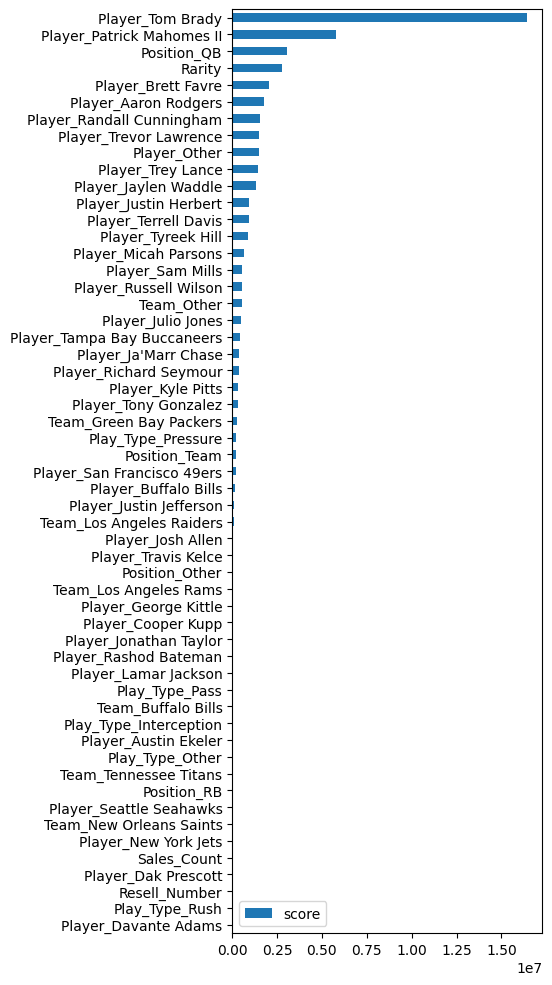

In [242]:
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

feature_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
feature_df.plot(kind='barh', figsize = (4,12))

In [267]:
# https://machinelearningmastery.com/xgboost-for-regression/
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
p = {'tree_method': 'hist',
 'use_label_encoder': False,
 'n_estimators': 1000,
 'random_state': 1234,
    }
m2 = xgb.XGBRegressor(
        # **p,
        tree_method='hist',
         use_label_encoder=False,
        enable_categorical=True,
        # max_cat_to_onehot=1,  # We use optimal partitioning exclusively
    )
results = cross_val_score(
    m2, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1
)
results2 = cross_val_score(
    m2, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1
)
results3 = cross_val_score(
    m2, X, y, cv=cv, n_jobs=-1
)

In [270]:
scores = np.absolute(results)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

scores2 = np.absolute(results2)
print('Mean MAPE: %.3f (%.3f)' % (scores2.mean(), scores2.std()) )

scores3 = np.absolute(results3)
print('Mean R2: %.3f (%.3f)' % (scores3.mean(), scores3.std()) )

Mean MAE: 14.962 (0.347)
Mean MAPE: 0.800 (0.004)
Mean R2: 0.692 (0.184)


In [26]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [112]:
X_samp = X.sample(frac=0.2, random_state=1234)

In [113]:
shap_samp = shap_values[X_samp.index.values]

In [114]:
len(shap_samp.values)

120555

In [115]:
len(X_samp)

120555

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


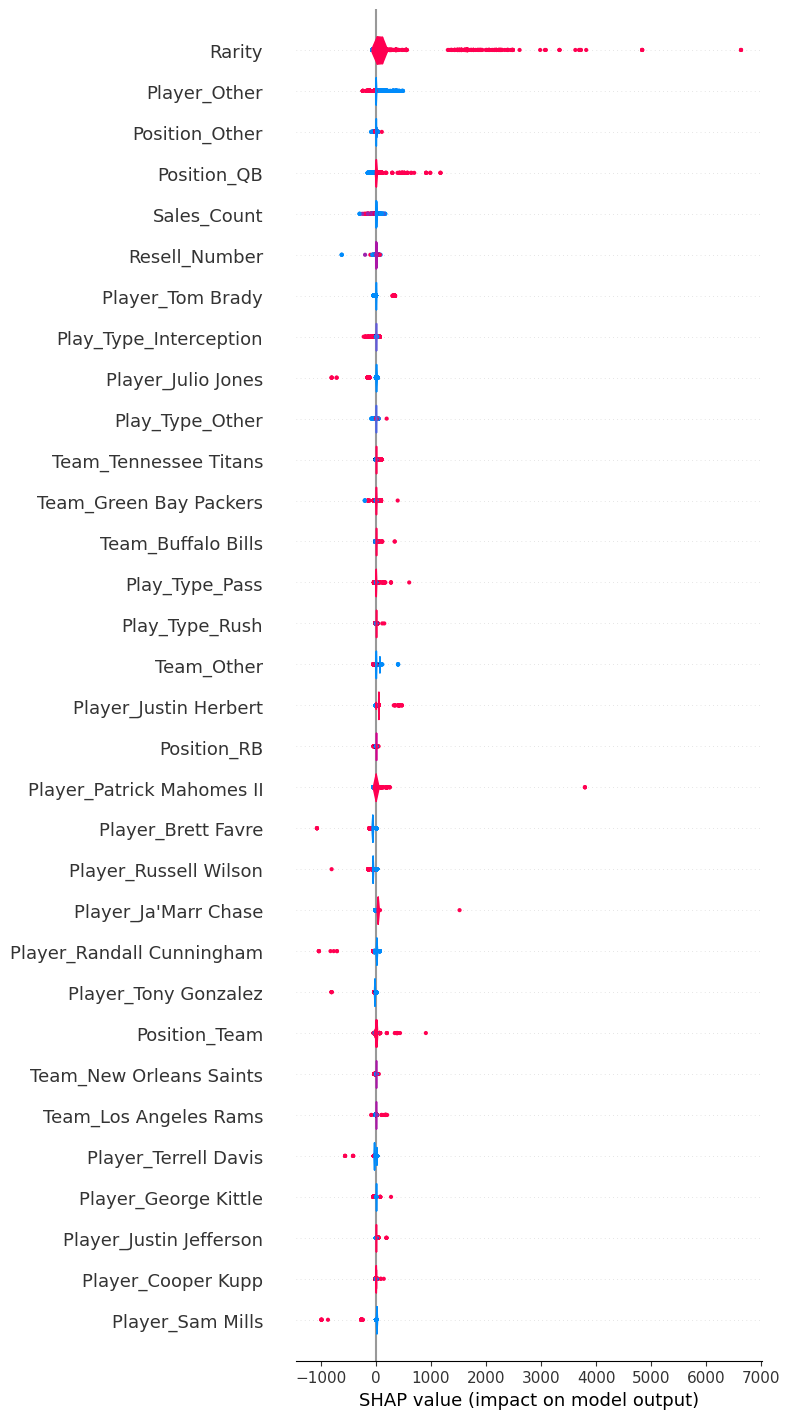

In [176]:
summary = shap.summary_plot(
    shap_samp, 
    X_samp,
    max_display=32,
    color_bar=False, # causes error
    plot_type='violin',
    show=False,
)

In [148]:
X_samp_small = X.sample(frac=0.01, random_state=1234)
shap_samp_small = shap_values[X_samp_small.index.values]

In [149]:
len(X_samp_small)

6028

In [150]:
explainer.expected_value,

(36.165863,)

In [156]:
shap_values.sum(1)

.values =
array([-27.784634, -17.703323, 261.71948 , ..., -24.552803, -22.116327,
       -20.19903 ], dtype=float32)

.data =
array([5, 5, 6, ..., 7, 8, 9])

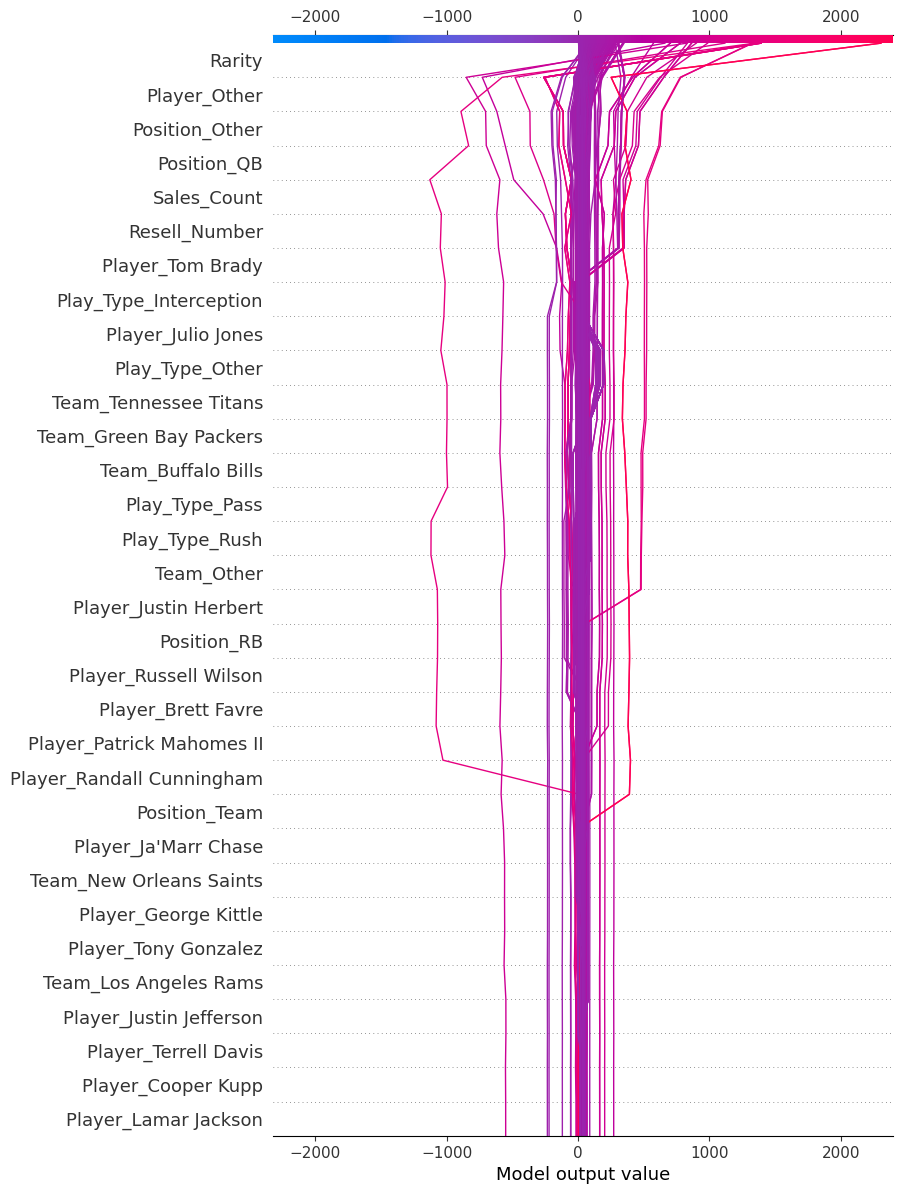

In [175]:
shap.decision_plot(explainer.expected_value, shap_samp_small.values, X_samp_small, feature_display_range=slice(-1, -33, -1), ignore_warnings=True)

In [171]:
X

,Sales_Count,Resell_Number,Rarity,Player_Aaron Rodgers,Player_Austin Ekeler,Player_Brett Favre,Player_Buffalo Bills,Player_Cooper Kupp,Player_Dak Prescott,Player_Davante Adams,...,Position_QB,Position_RB,Position_Team,Team_Buffalo Bills,Team_Green Bay Packers,Team_Los Angeles Raiders,Team_Los Angeles Rams,Team_New Orleans Saints,Team_Other,Team_Tennessee Titans
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602770,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
602771,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
602772,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
602773,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


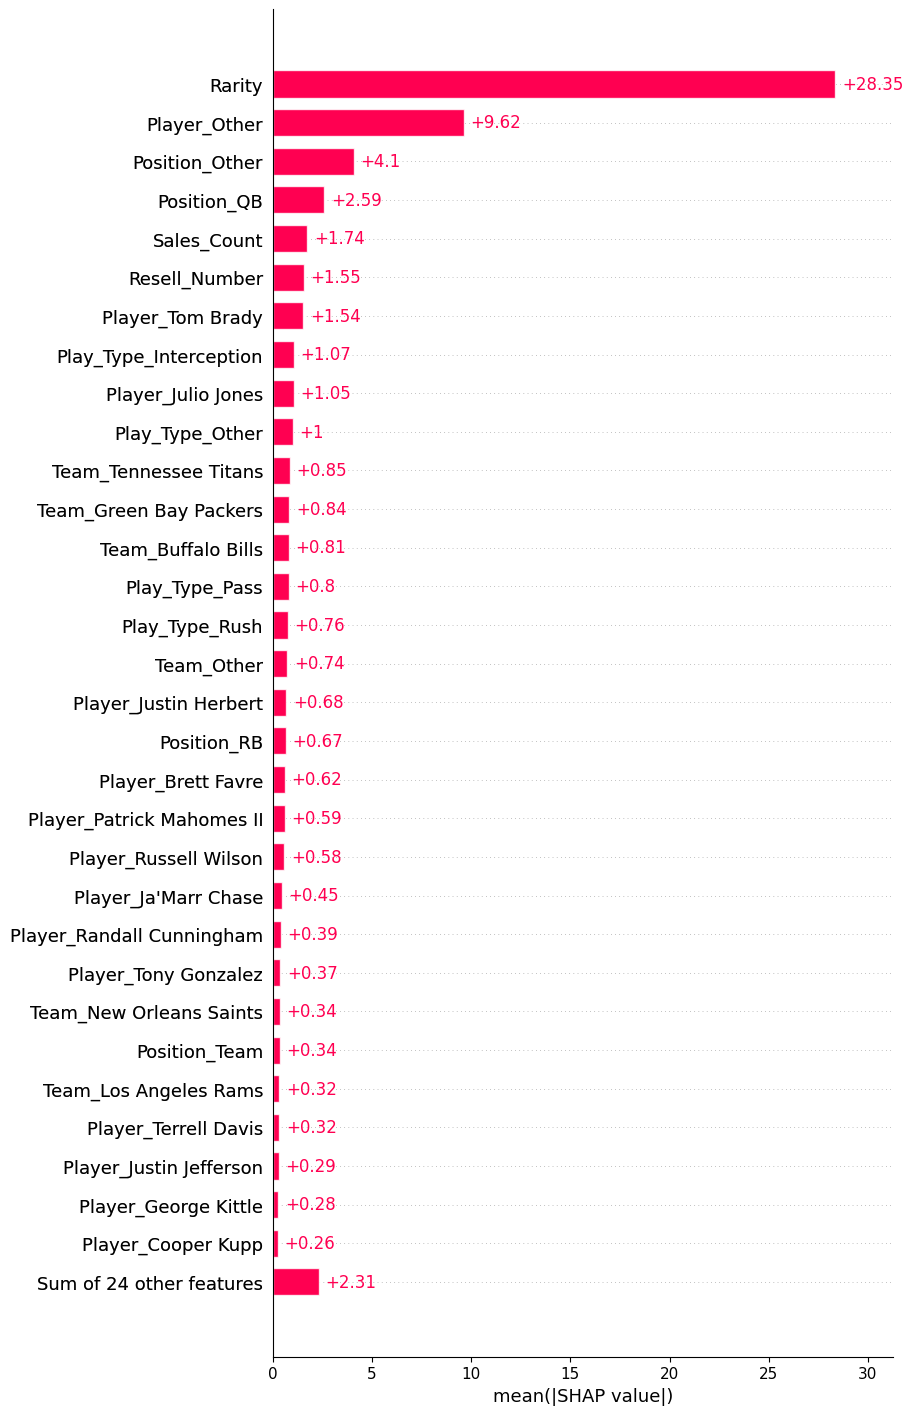

In [174]:
shap.plots.bar(shap_values, max_display=32)

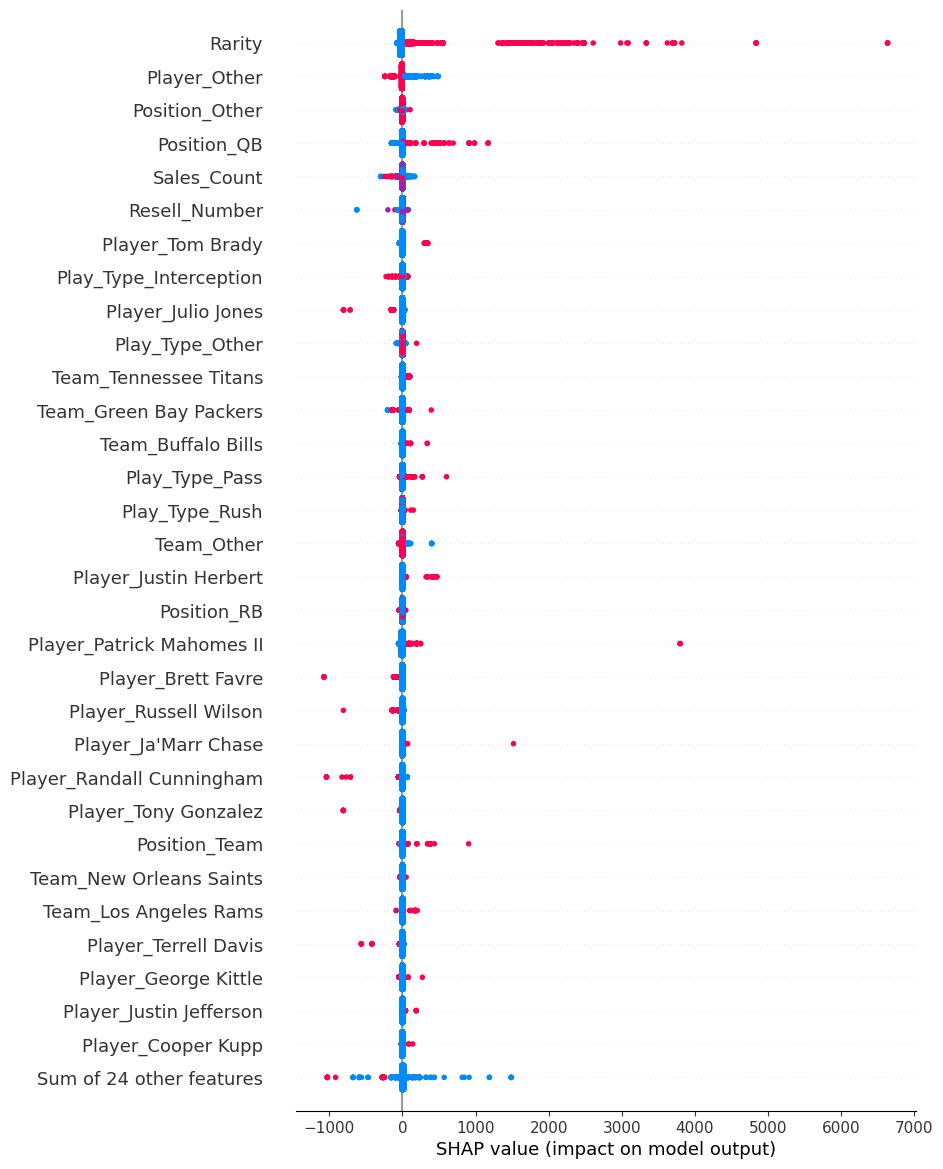

In [182]:
shap.plots.beeswarm(shap_samp, max_display=32, color_bar=False)

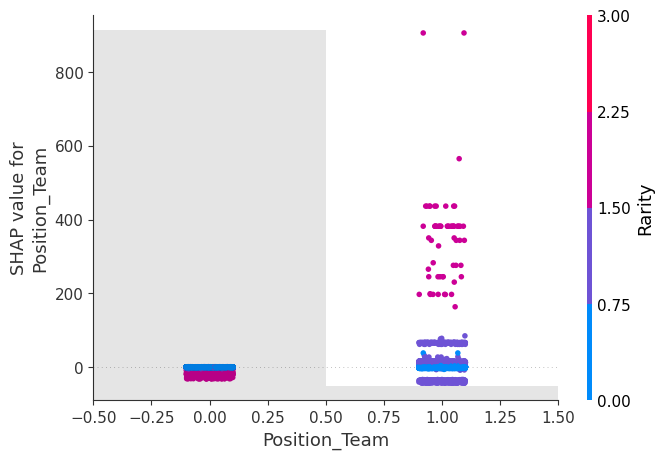

In [193]:
shap.plots.scatter(shap_values[:,"Position_Team"],color=shap_values)

In [197]:
shap_interaction_values = explainer.shap_interaction_values(X_samp)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


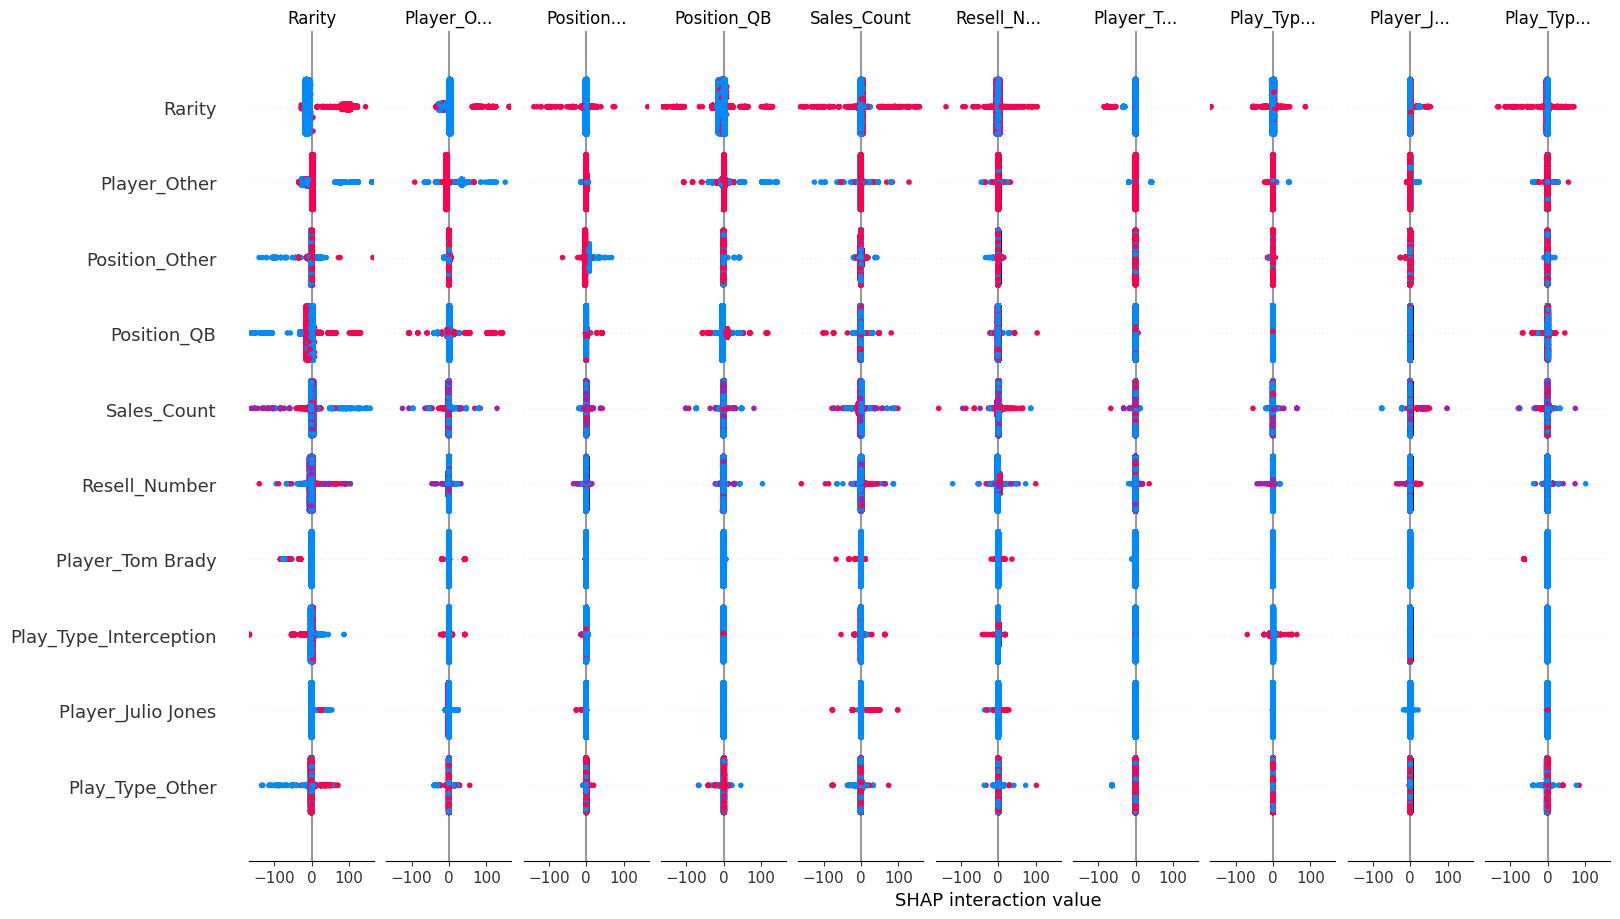

In [203]:
shap.summary_plot(shap_interaction_values, X_samp, max_display=10, color_bar=False)

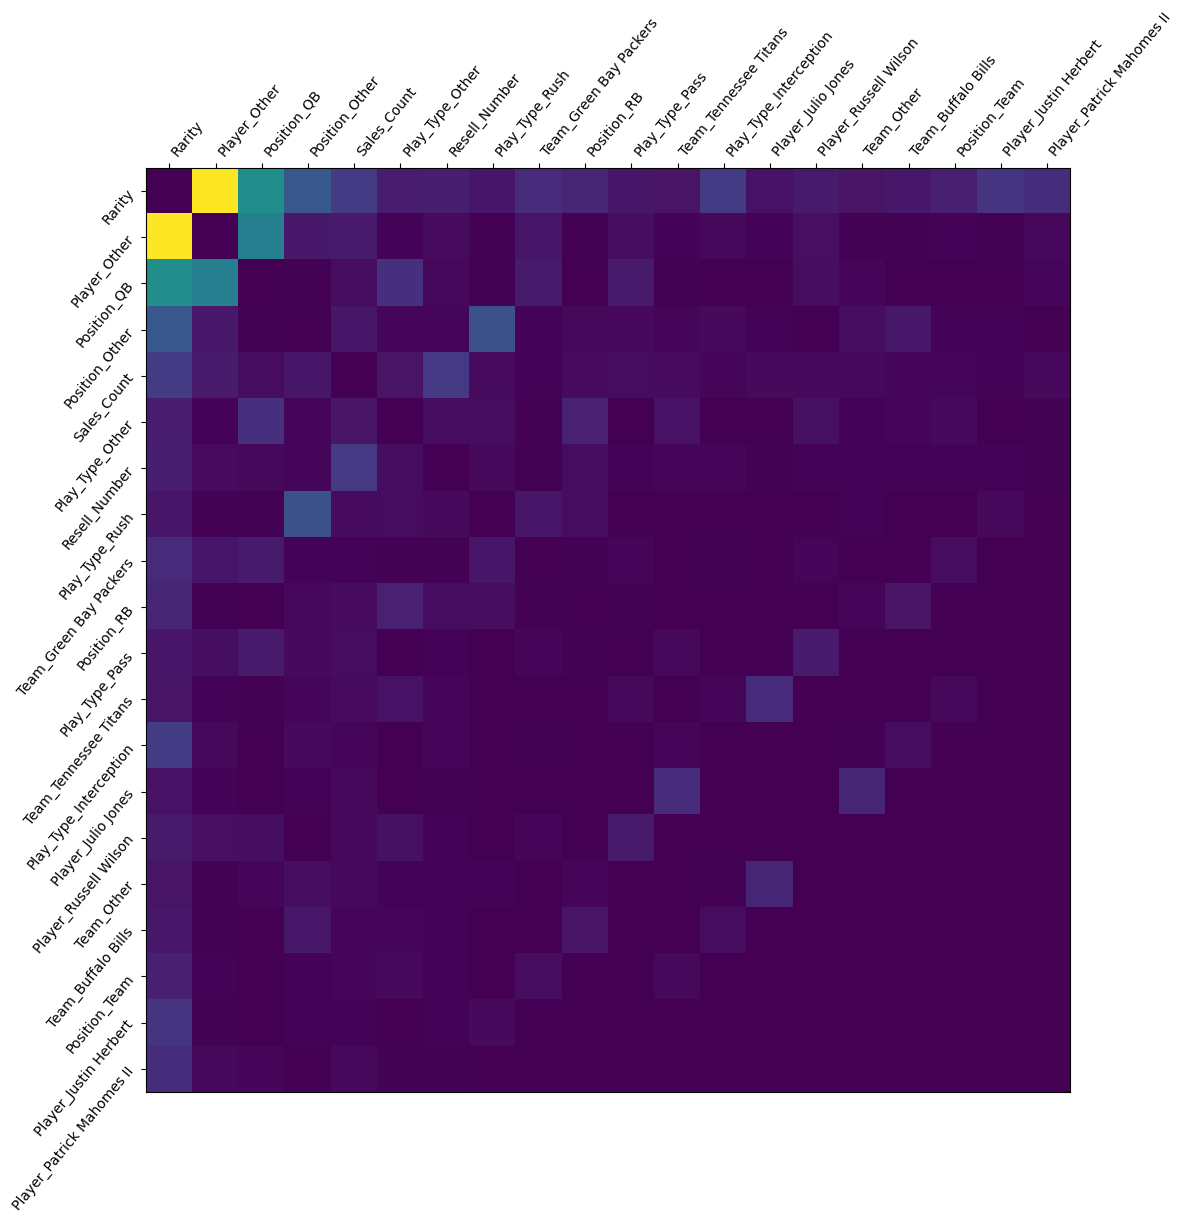

In [207]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:20]
tmp2 = tmp[inds,:][:,inds]
plt.figure(figsize=(12,12))
plt.imshow(tmp2)
plt.yticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right")
plt.xticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left")
plt.gca().xaxis.tick_top()
plt.show()

0
1
2
3
4
5


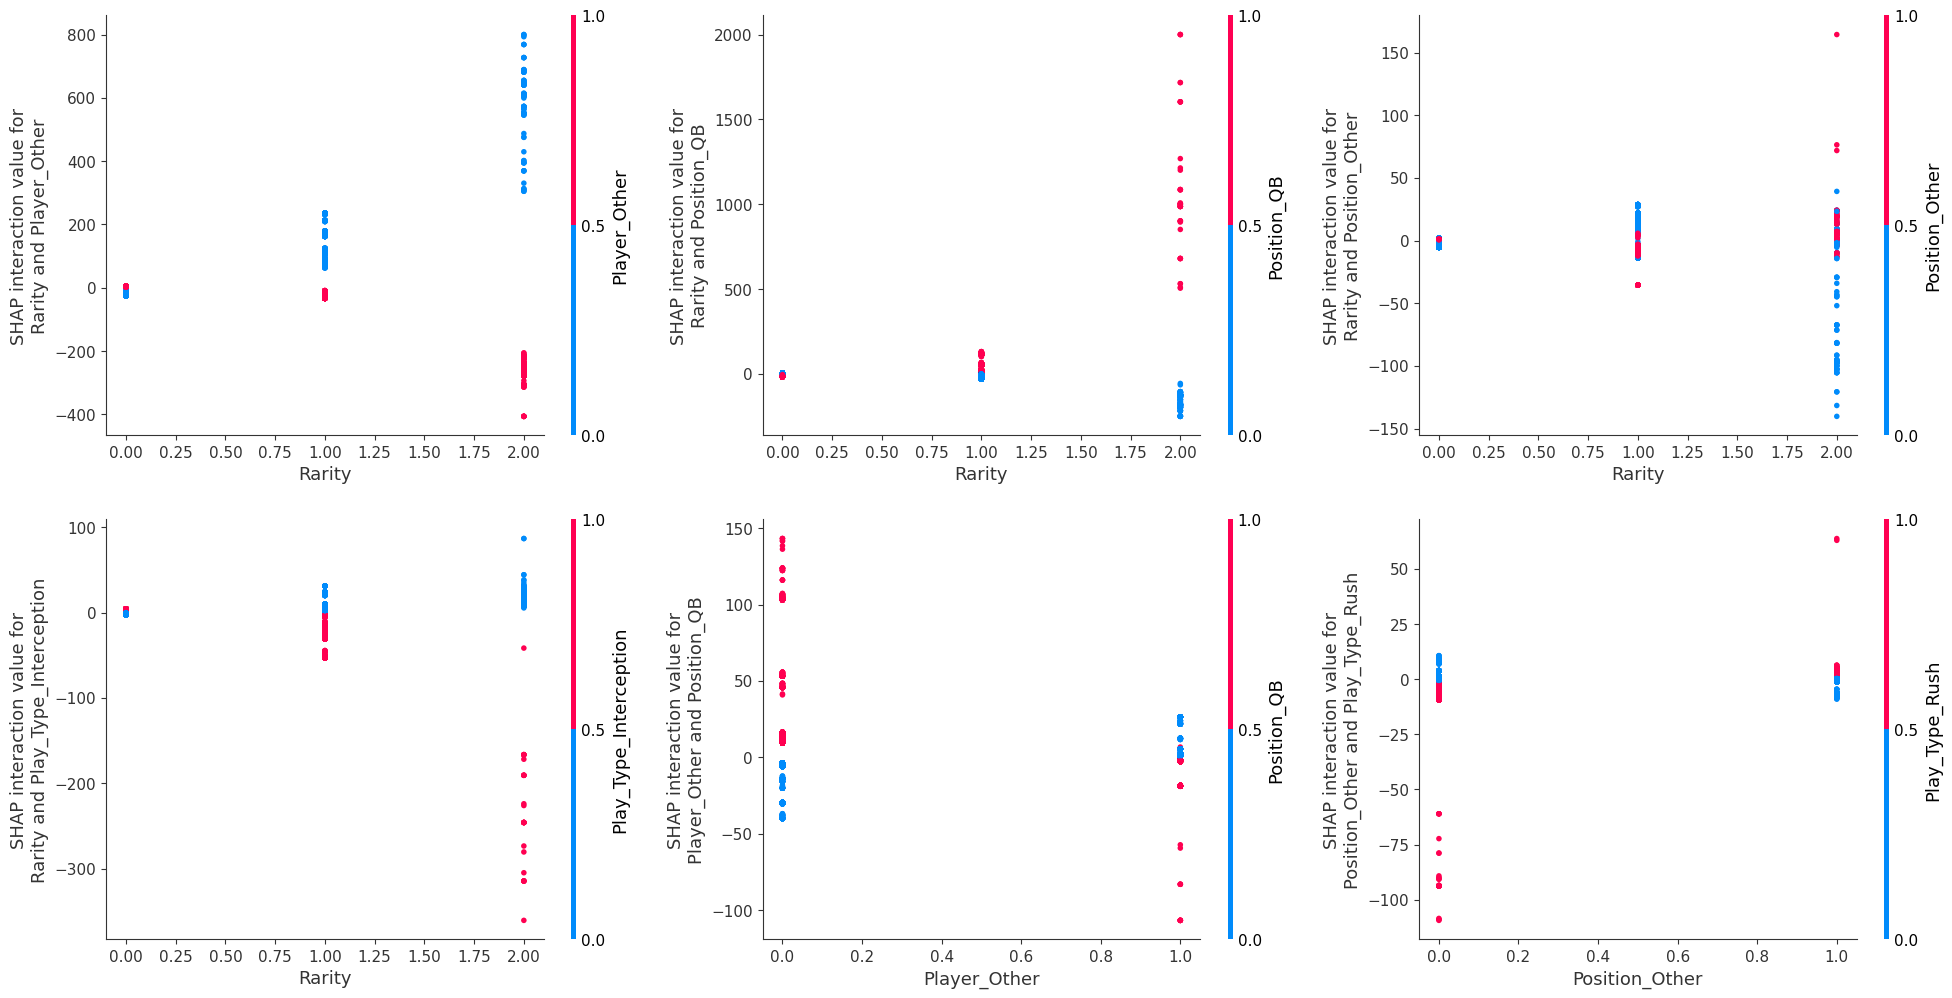

In [231]:
fig, axes = plt.subplots(2,3, figsize=(24,12))
pairs = [
    ('Rarity', 'Player_Other'),
    ('Rarity', 'Position_QB'),
    ('Rarity', 'Position_Other'),
    ('Rarity', 'Play_Type_Interception'),
    ('Player_Other', 'Position_QB'),
    ('Position_Other', "Play_Type_Rush"),

]
for i,x in enumerate(pairs):
    print(i)
    shap.dependence_plot(
        x,
        shap_interaction_values, X_samp,
        ax=axes.ravel()[i],
        show=False
    )

In [223]:
shap.dependence_plot?

Signature:
shap.dependence_plot(
    ind,
    shap_values=None,
    features=None,
    feature_names=None,
    display_features=None,
    interaction_index='auto',
    color='#1E88E5',
    axis_color='#333333',
    cmap=None,
    dot_size=16,
    x_jitter=0,
    alpha=1,
    title=None,
    xmin=None,
    xmax=None,
    ax=None,
    show=True,
    ymin=None,
    ymax=None,
)
Docstring:
Create a SHAP dependence plot, colored by an interaction feature.

Plots the value of the feature on the x-axis and the SHAP value of the same feature
on the y-axis. This shows how the model depends on the given feature, and is like a
richer extenstion of the classical parital dependence plots. Vertical dispersion of the
data points represents interaction effects. Grey ticks along the y-axis are data
points where the feature's value was NaN.


Parameters
----------
ind : int or string
    If this is an int it is the index of the feature to plot. If this is a string it is
    either the name of the featur

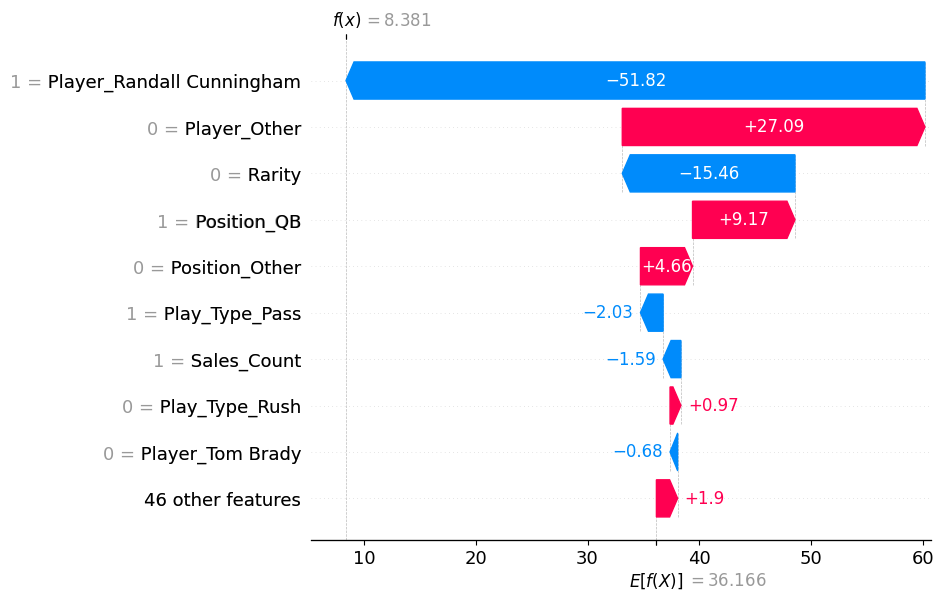

In [189]:
shap.plots.waterfall(shap_values[0])

In [ ]:
features = [
    "Player",
    "Play_Type",
    "Position",
    "Team",
    "Sales_Count",
    "Rarity",
    "Resell_Number"
    # "NFT_ID",
]

params = {
    "tree_method": "hist",
    "use_label_encoder": False,
    "n_estimators": 1000,
    "random_state": 1234,
    "early_stopping_rounds": 10,
}
X, y = df[features], df.Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

model = xgb.XGBRegressor(
        **params,
        enable_categorical=True,
        max_cat_to_onehot=1,  # We use optimal partitioning exclusively
    )
model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])

feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

feature_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
feature_df.plot(kind='barh', figsize = (4,12))

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

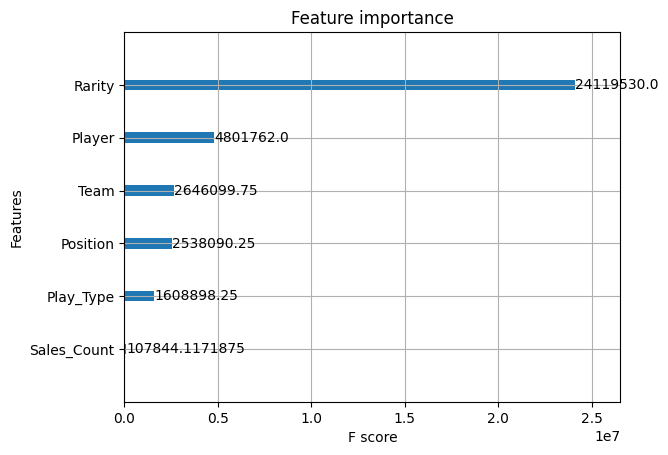

In [60]:
xgb.plot_importance(model.get_booster(), importance_type='gain')